In this notebook, we try data augmentation by generating new images from our original training dataset. Randomly applying width shift, height shift, brightness shift, channel shift and vertical flip, we generated 285 new images. The generated images are saved to the original folder with prefix 'gen'.
    
__Size of the datasets:__

- training set: 214+271=485 samples
- validation set: 72+14=86 samples
- test set: 71 samples

Then, we use the autmented data to train model 4 from notebook `classic_cnn`, resulting in both increased training accuracy and test accuracy.

__Result of model 4 with 50 epochs:__

- train accuracy: 1.0000 (previously 0.9860)
- test accuracy: 0.8873 (previously 0.8310)

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

np.random.seed(1)

Using TensorFlow backend.


# Data augmentation

In [2]:
datagen = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = (1.2, 1.5),
    channel_shift_range = 0.4,
    vertical_flip = True)

In [7]:
train_path = os.getcwd() + '/dataset2/training_set/'

for folder in os.listdir(train_path):
    for filename in os.listdir(train_path + str(folder)):
        if filename.split('.')[1] == 'jpg':
            pic = load_img(os.path.join(train_path + str(folder), filename))
            pic_array = img_to_array(pic)
            pic_array = pic_array.reshape((1,) + pic_array.shape)
            gen = datagen.flow(pic_array, batch_size = 2,
                                     save_to_dir = train_path + str(folder),
                                     save_prefix = 'gen',
                                     save_format='jpg')
            gen.next()

# Import training and test data

In [15]:
train_images = []       
train_labels = [] 
shape = (200,200)
train_path = os.getcwd() + '/dataset2/training_set/'

for folder in os.listdir(train_path):
    for filename in os.listdir(train_path + str(folder)):
        if filename.split('.')[1] == 'jpg':
            img = cv2.imread(os.path.join(train_path + str(folder), filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Spliting file names and storing the labels for image in list
            train_labels.append(str(folder))
            
            # Resize all images to a specific shape
            img = cv2.resize(img,shape)
            
            train_images.append(img)

# Converting labels into One Hot encoded sparse matrix
train_labels = pd.get_dummies(train_labels).values

# Converting train_images to array
train_images = np.array(train_images)

# Splitting Training data into train and validation dataset
x_train, x_val, y_train, y_val = train_test_split(train_images,
                                                  train_labels,
                                                  test_size = 0.15,
                                                  random_state = 1)

x_train = x_train/255.
x_val = x_val/255.

In [16]:
x_train.shape

(485, 200, 200, 3)

In [17]:
x_val.shape

(86, 200, 200, 3)

[1 0 0]


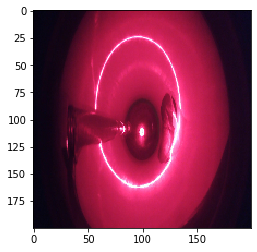

In [18]:
print(train_labels[0])
plt.imshow(train_images[0])

In [27]:
test_images = []
test_labels = []
shape = (200,200)
test_path = os.getcwd() + '/dataset2/test_set/'

for folder in os.listdir(test_path):
    for filename in os.listdir(test_path + str(folder)):
        if filename.split('.')[1] == 'jpg':
            img = cv2.imread(os.path.join(test_path + str(folder), filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Spliting file names and storing the labels for image in list
            test_labels.append(str(folder))

            # Resize all images to a specific shape
            img = cv2.resize(img,shape)

            test_images.append(img)
        
# Converting labels into One Hot encoded sparse matrix
test_labels = pd.get_dummies(test_labels).values        

# Converting test_images to array
test_images = np.array(test_images)

# ConvNet model 4

In model 4, we add dropout layers after the two pooling layers to introduce regularization.

In [57]:
model4 = Sequential()
model4.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (200,200,3,)))
model4.add(Conv2D(32, (3,3), activation = 'relu'))
model4.add(MaxPool2D(2,2))
model4.add(Dropout(0.25))
model4.add(Conv2D(32, (3,3), activation = 'relu'))
model4.add(MaxPool2D(2,2))
model4.add(Dropout(0.25))
model4.add(Conv2D(64, (3,3), activation = 'relu'))

model4.add(Flatten())

model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(15, activation = 'relu'))
model4.add(Dense(3, activation = 'softmax'))
    
model4.compile(loss = 'categorical_crossentropy', 
              metrics = ['acc'],
              optimizer = 'adam')

In [58]:
model4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 48, 48, 32)      

In [59]:
history4 = model4.fit(x_train, y_train,
                    epochs = 50, batch_size = 16,
                    validation_data = (x_val, y_val))

Train on 485 samples, validate on 86 samples
Epoch 1/50
485/485 [==============================] - 25s 51ms/step - loss: 1.0783 - acc: 0.5052 - val_loss: 0.9771 - val_acc: 0.5000
Epoch 2/50
485/485 [==============================] - 22s 46ms/step - loss: 0.9670 - acc: 0.5175 - val_loss: 0.9271 - val_acc: 0.5000
Epoch 3/50
485/485 [==============================] - 22s 45ms/step - loss: 0.9759 - acc: 0.5196 - val_loss: 0.9924 - val_acc: 0.4884
Epoch 4/50
485/485 [==============================] - 22s 45ms/step - loss: 0.9290 - acc: 0.5258 - val_loss: 0.8887 - val_acc: 0.5349
Epoch 5/50
485/485 [==============================] - 23s 47ms/step - loss: 0.8356 - acc: 0.5897 - val_loss: 0.8545 - val_acc: 0.5581
Epoch 6/50
485/485 [==============================] - 22s 46ms/step - loss: 0.6964 - acc: 0.6969 - val_loss: 0.9024 - val_acc: 0.6744
Epoch 7/50
485/485 [==============================] - 22s 46ms/step - loss: 0.5259 - acc: 0.8103 - val_loss: 0.7374 - val_acc: 0.6977
Epoch 8/50
485/48

## Summary of result

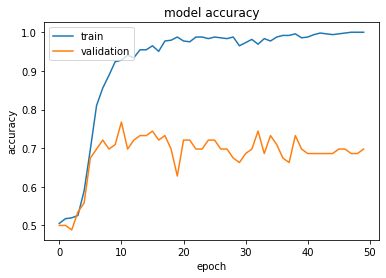

In [60]:
# summarize history for accuracy
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

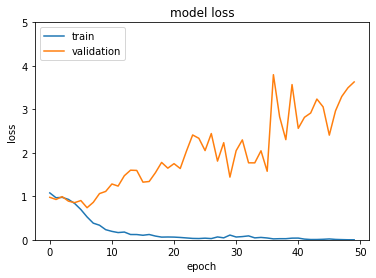

In [61]:
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,5)
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [62]:
# Evaluating model on test data
evaluate4 = model4.evaluate(test_images, test_labels)
print(evaluate4) # loss and accuracy

71/71 [==============================] - 1s 16ms/step
[299.89268987951147, 0.8873239159584045]



- train accuracy: 1.0000
- validation accuracy: 0.6977 
- test accuracy: 0.8873
